# Extreme Modeling: Stacking Ensemble with Optuna

## Strategy: Kaggle Grandmaster Style
1. **Optuna HPO**: XGBoost, LightGBM, CatBoost 최적 파라미터 탐색
2. **OOF Prediction**: 과적합 없는 메타 피처 생성
3. **Stacking**: Logistic Regression 메타 모델로 최종 예측

In [15]:
!pip install xgboost lightgbm catboost optuna scikit-learn pandas numpy matplotlib seaborn

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import optuna
import warnings

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

SEED = 42
N_TRIALS = 30  # Optuna 탐색 횟수

REPO_URL = 'https://raw.githubusercontent.com/choicompany/bdadacon/main'
TRAIN_URL = f'{REPO_URL}/preprocessing/train_processed.csv'
TEST_URL = f'{REPO_URL}/preprocessing/test_processed.csv'
RAW_TEST_URL = f'{REPO_URL}/rawdata/test.csv'

## 1. Data Loading & Preprocessing
**핵심**: 컬럼명 중복 문제를 해결하기 위해 고유 인덱스를 붙임

In [17]:
def make_unique_columns(df):
    """
    1. 특수문자 제거 (XGBoost, LightGBM 호환성)
    2. 중복 컬럼명에 인덱스 붙여 고유화
    """
    # Step 1: 특수문자 제거
    new_cols = [re.sub(r'[^A-Za-z0-9_]+', '_', str(col)) for col in df.columns]
    
    # Step 2: 중복 이름에 숫자 붙이기
    seen = {}
    unique_cols = []
    for col in new_cols:
        if col in seen:
            seen[col] += 1
            unique_cols.append(f"{col}_{seen[col]}")
        else:
            seen[col] = 0
            unique_cols.append(col)
    
    df.columns = unique_cols
    return df

# 데이터 로드
train_df = pd.read_csv(TRAIN_URL)
test_df = pd.read_csv(TEST_URL)

train_df = make_unique_columns(train_df)
test_df = make_unique_columns(test_df)

# X, y 분리
X = train_df.drop(columns=['completed'])
y = train_df['completed']
X_test = test_df.copy()

# Numpy 변환 (XGBoost dtype 에러 완전 차단)
X_np = X.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_np = y.values
feature_names = list(X.columns)

print(f"Data Loaded. Train: {X_np.shape}, Test: {X_test_np.shape}")
print(f"Unique columns: {len(set(X.columns))} / {len(X.columns)}")

Data Loaded. Train: (748, 156), Test: (814, 156)
Unique columns: 156 / 156


## 2. Optuna Hyperparameter Optimization

In [18]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': SEED,
        'n_jobs': -1,
        'tree_method': 'hist'
    }
    model = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = cross_val_score(model, X_np, y_np, cv=cv, scoring='accuracy', n_jobs=-1)
    return scores.mean()

def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 16, 64),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': SEED,
        'n_jobs': -1,
        'verbose': -1
    }
    model = LGBMClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = cross_val_score(model, X_np, y_np, cv=cv, scoring='accuracy', n_jobs=-1)
    return scores.mean()

def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 800),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_seed': SEED,
        'verbose': 0,
        'allow_writing_files': False
    }
    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = cross_val_score(model, X_np, y_np, cv=cv, scoring='accuracy', n_jobs=-1)
    return scores.mean()

In [19]:
print("=== Optuna Optimization ===")

print("Optimizing XGBoost...")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS, show_progress_bar=True)
print(f"  Best XGB CV Score: {study_xgb.best_value:.4f}")

print("Optimizing LightGBM...")
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS, show_progress_bar=True)
print(f"  Best LGBM CV Score: {study_lgbm.best_value:.4f}")

print("Optimizing CatBoost...")
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=N_TRIALS, show_progress_bar=True)
print(f"  Best CatBoost CV Score: {study_cat.best_value:.4f}")

print("\n=== Best Parameters ===")
print(f"XGB: {study_xgb.best_params}")
print(f"LGBM: {study_lgbm.best_params}")
print(f"CatBoost: {study_cat.best_params}")

=== Optuna Optimization ===
Optimizing XGBoost...


  0%|          | 0/30 [00:00<?, ?it/s]

  Best XGB CV Score: 0.7032
Optimizing LightGBM...


  0%|          | 0/30 [00:00<?, ?it/s]

  Best LGBM CV Score: 0.7045
Optimizing CatBoost...


  0%|          | 0/30 [00:00<?, ?it/s]

  Best CatBoost CV Score: 0.6992

=== Best Parameters ===
XGB: {'n_estimators': 789, 'max_depth': 10, 'learning_rate': 0.012210744497783341, 'subsample': 0.723269727473774, 'colsample_bytree': 0.9974717430223475, 'reg_alpha': 9.791993145981893, 'reg_lambda': 4.25326843920418}
LGBM: {'n_estimators': 496, 'max_depth': 7, 'learning_rate': 0.09550782199746741, 'num_leaves': 64, 'subsample': 0.8019267466685853, 'colsample_bytree': 0.8332535279094322, 'reg_alpha': 7.955496656997584, 'reg_lambda': 7.384484491698464}
CatBoost: {'iterations': 385, 'depth': 10, 'learning_rate': 0.035172730516970646, 'l2_leaf_reg': 3.7713585615903242}


## 3. OOF Prediction & Stacking

In [20]:
def get_oof_predictions(model, X_train, y_train, X_test, n_splits=5):
    """
    Out-Of-Fold 예측값 생성
    - oof_train: 메타 모델 학습용
    - oof_test: 최종 테스트 예측 (Fold 평균)
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof_train = np.zeros(len(X_train))
    oof_test = np.zeros(len(X_test))
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        model.fit(X_tr, y_tr)
        oof_train[val_idx] = model.predict_proba(X_val)[:, 1]
        oof_test += model.predict_proba(X_test)[:, 1] / n_splits
    
    return oof_train, oof_test

# 최적 파라미터로 모델 생성
xgb_model = XGBClassifier(**study_xgb.best_params, random_state=SEED, n_jobs=-1, tree_method='hist')
lgbm_model = LGBMClassifier(**study_lgbm.best_params, random_state=SEED, n_jobs=-1, verbose=-1)
cat_model = CatBoostClassifier(**study_cat.best_params, random_seed=SEED, verbose=0, allow_writing_files=False)

print("Generating OOF Predictions...")
xgb_oof_train, xgb_oof_test = get_oof_predictions(xgb_model, X_np, y_np, X_test_np)
print(f"  XGB OOF done. Train acc: {accuracy_score(y_np, (xgb_oof_train >= 0.5).astype(int)):.4f}")

lgbm_oof_train, lgbm_oof_test = get_oof_predictions(lgbm_model, X_np, y_np, X_test_np)
print(f"  LGBM OOF done. Train acc: {accuracy_score(y_np, (lgbm_oof_train >= 0.5).astype(int)):.4f}")

cat_oof_train, cat_oof_test = get_oof_predictions(cat_model, X_np, y_np, X_test_np)
print(f"  CatBoost OOF done. Train acc: {accuracy_score(y_np, (cat_oof_train >= 0.5).astype(int)):.4f}")

Generating OOF Predictions...
  XGB OOF done. Train acc: 0.7032
  LGBM OOF done. Train acc: 0.7045
  CatBoost OOF done. Train acc: 0.6992


In [21]:
# Meta Features 생성
X_train_meta = np.column_stack([xgb_oof_train, lgbm_oof_train, cat_oof_train])
X_test_meta = np.column_stack([xgb_oof_test, lgbm_oof_test, cat_oof_test])

# Meta Model: Logistic Regression
meta_model = LogisticRegression(random_state=SEED, max_iter=1000)
meta_model.fit(X_train_meta, y_np)

# Stacking CV Score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
meta_cv_scores = cross_val_score(meta_model, X_train_meta, y_np, cv=skf, scoring='accuracy')
print(f"\n=== Stacking Ensemble CV Score ===")
print(f"Mean Accuracy: {meta_cv_scores.mean():.4f} (+/- {meta_cv_scores.std():.4f})")

print("\nMeta Model Weights:")
for name, coef in zip(['XGB', 'LGBM', 'CatBoost'], meta_model.coef_[0]):
    print(f"  {name}: {coef:.4f}")


=== Stacking Ensemble CV Score ===
Mean Accuracy: 0.6992 (+/- 0.0066)

Meta Model Weights:
  XGB: 0.6550
  LGBM: 0.2637
  CatBoost: 0.9532


In [22]:
# Final Prediction
final_probs = meta_model.predict_proba(X_test_meta)[:, 1]
final_preds = (final_probs >= 0.5).astype(int)

# Save Submission
raw_test = pd.read_csv(RAW_TEST_URL)
submission = pd.DataFrame({
    'ID': raw_test['ID'],
    'completed': final_preds
})
submission.to_csv('submission_stacking_optuna.csv', index=False)
print("Saved: submission_stacking_optuna.csv")
print(submission.head())

Saved: submission_stacking_optuna.csv
         ID  completed
0  TEST_000          0
1  TEST_001          0
2  TEST_002          0
3  TEST_003          0
4  TEST_004          0


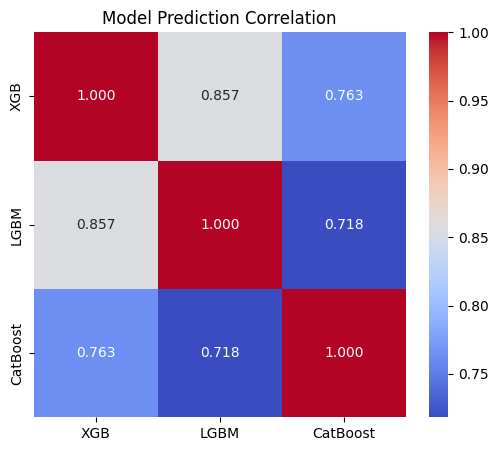

In [23]:
# Correlation between base models
oof_df = pd.DataFrame({'XGB': xgb_oof_train, 'LGBM': lgbm_oof_train, 'CatBoost': cat_oof_train})
plt.figure(figsize=(6, 5))
sns.heatmap(oof_df.corr(), annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Model Prediction Correlation')
plt.show()

In [31]:
# Final Prediction with Threshold Adjustment
final_probs = meta_model.predict_proba(X_test_meta)[:, 1]

# Threshold 조정: 학습 데이터의 target 비율 사용 (약 0.3)
threshold = y_np.mean()
print(f"\nApplying Threshold: {threshold:.4f}")
print(f"Test Prob Stats: Min={final_probs.min():.4f}, Max={final_probs.max():.4f}, Mean={final_probs.mean():.4f}")

final_preds = (final_probs >= threshold).astype(int)
print(f"Predicted 0s: {(final_preds == 0).sum()}, 1s: {(final_preds == 1).sum()}")

# Save Submission
raw_test = pd.read_csv(RAW_TEST_URL)
submission = pd.DataFrame({
    'ID': raw_test['ID'],
    'completed': final_preds
})
submission.to_csv('submission.csv', index=False)
print("Saved: submission.csv")
print(submission.head())


Applying Threshold: 0.2981
Test Prob Stats: Min=0.2401, Max=0.4300, Mean=0.3032
Predicted 0s: 395, 1s: 419
Saved: submission.csv
         ID  completed
0  TEST_000          0
1  TEST_001          1
2  TEST_002          0
3  TEST_003          1
4  TEST_004          0
